In [37]:
import warnings as warn
warn.filterwarnings('ignore')

In [38]:
!pip install roboflow
!pip install ultralytics


In [39]:
!pip install MTCNN

In [40]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN
from tqdm import tqdm

In [41]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

In [42]:
import kagglehub
import os

# Download FER2013
fer_path = kagglehub.dataset_download("msambare/fer2013")
print("FER2013 dataset path:", fer_path)

FER2013 dataset path: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [54]:
fer_path = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
yolo_base = "/kaggle/working/FER2013-YOLO"

classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
class_to_id = {cls: i for i, cls in enumerate(classes)}

# Detector
detector = MTCNN()

In [44]:
for split in ["train", "test"]:
    os.makedirs(os.path.join(yolo_base, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_base, "labels", split), exist_ok=True)

In [57]:
def process_split(split):
    src_dir = os.path.join(fer_path, split)
    # Ensure the base output directory exists
    os.makedirs(os.path.join(yolo_base, "images", split), exist_ok=True)
    os.makedirs(os.path.join(yolo_base, "labels", split), exist_ok=True)

    for cls in classes:
        img_dir = os.path.join(src_dir, cls)
        if not os.path.exists(img_dir): continue

        for img_file in tqdm(os.listdir(img_dir), desc=f"{split}-{cls}"):
            if not img_file.endswith((".jpg", ".png")):
                continue

            img_path = os.path.join(img_dir, img_file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            h, w, _ = img.shape
            detections = detector.detect_faces(img)

            if len(detections) > 0:
                x, y, w_box, h_box = detections[0]["box"]
                x = max(0, x); y = max(0, y)

                x_center = (x + w_box/2) / w
                y_center = (y + h_box/2) / h
                width = w_box / w
                height = h_box / h

                cls_id = class_to_id[cls]

                # Ensure the output file has a .jpg extension
                out_img_name = img_file.rsplit('.', 1)[0] + '.jpg'
                out_img = os.path.join(yolo_base, "images", split, out_img_name)
                cv2.imwrite(out_img, img)

                label_path = os.path.join(yolo_base, "labels", split, out_img_name.replace(".jpg", ".txt"))
                with open(label_path, "w") as f:
                    f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

process_split("train")
process_split("test")

print("✅ FER2013 converted to YOLO format:", yolo_base)

test-neutral: 100%|██████████| 1233/1233 [01:32<00:00, 13.28it/s]

✅ FER2013 converted to YOLO format: /kaggle/working/FER2013-YOLO


In [58]:
yaml_content = f"""
train: {yolo_base}/images/train
val: {yolo_base}/images/test

nc: 7
names: {classes}
"""

yaml_path = "/kaggle/working/data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(" data.yaml created at:", yaml_path)


 data.yaml created at: /kaggle/working/data.yaml


In [59]:
# Train
model.train(
    data=yaml_path,
    epochs=30,
    imgsz=64,
    batch=64,
    name="yolo-fer2013",
    project="/kaggle/working"
)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo-fer201313, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78cf13d02bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [ ]:
model.save("Face_emotion.pt")

In [60]:
metrics = model.val()
print("Validation metrics:", metrics)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 113.5±48.0 MB/s, size: 1.8 KB)
val: Scanning /kaggle/working/FER2013-YOLO/labels/test.cache... 5986 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5986/5986 9.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 375/375 16.2it/s 23.2s
                   all       5986       5986      0.526      0.656      0.594      0.521
                 angry        788        788      0.443      0.668      0.561      0.485
               disgust         84         84       0.52      0.238      0.315      0.291
                  fear        820        820      0.341      0.573      0.419       0.37
                 happy       1528       1528      0.819      0.889      0.933       0.82
                   sad        96


image 1/1 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_75638667.jpg: 64x64 1 surprise, 9.6ms
Speed: 0.5ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 64, 64)


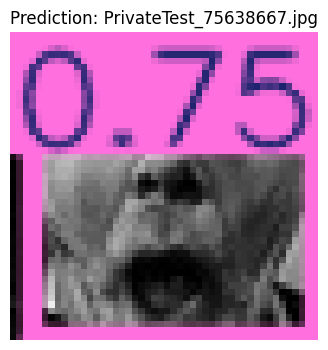


image 1/1 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_62709406.jpg: 64x64 1 happy, 10.0ms
Speed: 0.4ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 64, 64)


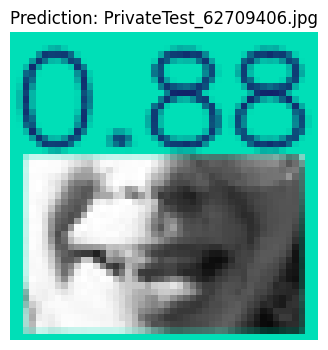


image 1/1 /kaggle/working/FER2013-YOLO/images/test/PublicTest_61791922.jpg: 64x64 1 fear, 1 happy, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 64, 64)


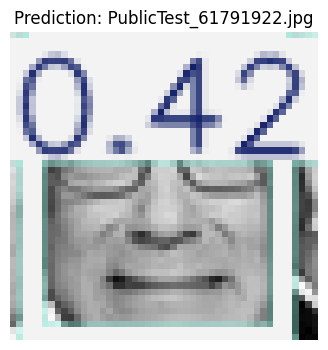

In [61]:
import random
import matplotlib.pyplot as plt

test_images = os.listdir(f"{yolo_base}/images/test")
sample_imgs = random.sample(test_images, 3)

for img_file in sample_imgs:
    img_path = os.path.join(yolo_base, "images", "test", img_file)
    results = model.predict(img_path, conf=0.25)
    im_bgr = results[0].plot()
    im_rgb = im_bgr[..., ::-1]

    plt.figure(figsize=(4, 4))
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.title(f"Prediction: {img_file}")
    plt.show()

In [65]:
model = YOLO("yolo11m.pt")

In [66]:
model.train(
    data="/kaggle/working/data.yaml",   # your FER2013 YOLO data config
    epochs=70,                         # more epochs for better convergence
    imgsz=128,                          # higher resolution than 64
    batch=32,                           # balanced batch size
    optimizer="AdamW",                  # better optimizer than SGD
    lr0=1e-3,                           # initial learning rate
    lrf=1e-4,                           # final learning rate
    dropout=0.05,                       # light dropout for generalization
    label_smoothing=0.1,                # reduce overconfidence
    patience=20,                        # early stopping
    augment=True,                       # enable built-in augmentations
    name="yolo-fer2013-optimized",
    project="/kaggle/working"
)


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.05, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo-fer2013-optimized, nbs=64, nms=False, opset=None, optim

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78d18de225a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [67]:
metrics = model.val()
print("Validation metrics:", metrics)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,035,429 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 122.0±51.2 MB/s, size: 1.8 KB)
val: Scanning /kaggle/working/FER2013-YOLO/labels/test.cache... 5986 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5986/5986 11.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 375/375 14.1it/s 26.6s
                   all       5986       5986      0.676      0.655      0.722      0.653
                 angry        788        788      0.663      0.565      0.687      0.608
               disgust         84         84      0.482      0.512      0.562      0.538
                  fear        820        820      0.626      0.479       0.59      0.535
                 happy       1528       1528      0.898      0.902      0.958      0.864
                   sad       

In [ ]:
model.save("Face_emotion_affectnet_final.pt")

In [69]:
def eval_and_metrics(model, yaml, split="test"):
    res = model.val(data=yaml, split=split)
    prec, rec, mAP50, mAP5095 = res.mean_results()
    return prec, rec, mAP50, mAP5095

Streaming output truncated to the last 5000 lines.
image 991/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40317032.jpg: 128x128 1 happy, 11.5ms
image 992/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40354251.jpg: 128x128 1 surprise, 9.4ms
image 993/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40374609.jpg: 128x128 1 happy, 9.1ms
image 994/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40404994.jpg: 128x128 1 surprise, 12.5ms
image 995/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40479989.jpg: 128x128 1 happy, 10.3ms
image 996/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40576680.jpg: 128x128 1 neutral, 10.3ms
image 997/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40584155.jpg: 128x128 1 surprise, 12.0ms
image 998/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40593216.jpg: 128x128 1 happy, 10.0ms
image 999/5986 /kaggle/working/FER2013-YOLO/images/test/PrivateTest_40614798.jpg: 128x128 1 

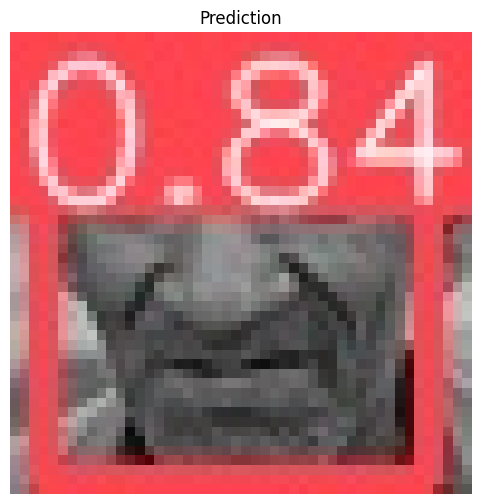

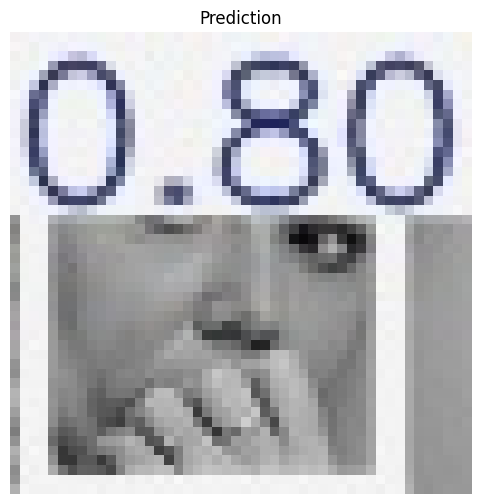

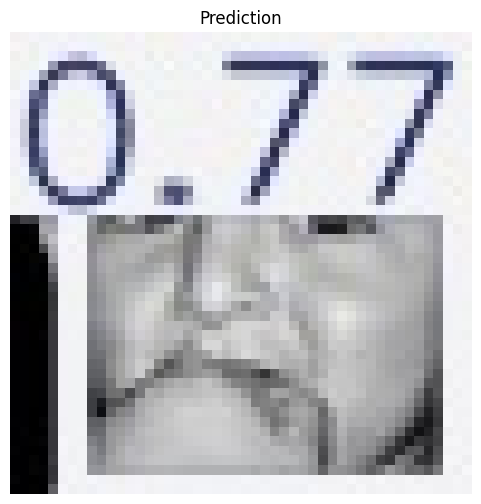

In [71]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# Update the path to the best.pt file based on the training output directory
best_model_path = "/kaggle/working/yolo-fer2013-optimized/weights/best.pt"

model = YOLO(best_model_path)
test_dir = "/kaggle/working/FER2013-YOLO/images/test"
results = model.predict(source=test_dir, conf=0.25, save=True, save_txt=True)
print(" Inference complete. Results saved in:", results[0].save_dir)

output_dir = results[0].save_dir
sample_images = os.listdir(output_dir)
sample_images = [img for img in sample_images if img.endswith((".jpg", ".png"))][:3]

for img_name in sample_images:
    img_path = os.path.join(output_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Prediction")
    plt.show()

In [72]:
metrics = model.val()
print("Validation metrics:", metrics)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 130.1±43.2 MB/s, size: 1.9 KB)
val: Scanning /kaggle/working/FER2013-YOLO/labels/test.cache... 5986 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5986/5986 11.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 375/375 14.3it/s 26.3s
                   all       5986       5986      0.676      0.655      0.722      0.653
                 angry        788        788      0.663      0.565      0.687      0.608
               disgust         84         84      0.482      0.512      0.562      0.538
                  fear        820        820      0.626      0.479       0.59      0.535
                 happy       1528       1528      0.898      0.902      0.958      0.864
                   sad        966        966        0.6      0.545      0.617       0.54
              surprise   